# Inner core anisotropy

In this practical, you will make body wave measurements of inner core anisotropy and determine regional variations in the strength of the anisotropic structure. 

The practical is based on:
Irving, J.C.E. and Deuss, A., 2011. Hemispherical structure in inner core velocity anisotropy. Journal of Geophysical Research: Solid Earth, 116(B4)
and a paper practical written by these authors. 

We start with importing the required python libraries. This only needs to happen once 

In [6]:
%matplotlib inline
from platform import python_version
print(python_version())
import obspy # Python toolkit for common routines in seismology
from obspy.clients.fdsn import Client
client = Client("IRIS") # Allows data download from IRIS
from obspy import UTCDateTime # Converts strings of dates 
from obspy.taup import TauPyModel # Predicts travel times
import numpy as np # General array seismology routines
import matplotlib.pyplot as plt # Plotting routines
import cartopy
import cartopy.crs as ccrs # To plot maps
import math # For some cos and sin functions


3.12.2


## I. PKIKP-PKP differential times

In this practial, you will make body wave measurements of inner core anisotropy and determine regional variations in the strength of the anisotropic structure.  You will compare travel times of phases that travel through the inner core, to those which only travel through the outer core.  Of the three PKP branches (see Figure 3), PKIKP travels through the inner core (and is also known as PKPdf). PKPab and PKPbc travel through the outer core only.


![alt text](PKPphases.png "Phases sampling the inner and outer core")
###### Figure 1 (a) Travel time curves for inner core compressional wave PKIKP (or PKPdf), its reference phases PKPbc, PKPab and PKiKP, and inner core shear wave PKJKP. (b) Corresponding ray paths through the Earth, for an epicentral distance of 150 degrees). From Deuss (2014) 


1.   Which outer core phase, PKPab or PKPbc, is a more suitable reference phase to study inner core structure? Why do we use a reference phase? Note that sometimes PKiKP is used as well, but as this is a reflected wave, it is very weak and challenging to use. 


## II. Load data
Firstly, we load our data sets. This only needs to happen once. 

In [7]:
# load observed seismograms
observed_seismograms = obspy.read("observed_seismograms.mseed", format="MSEED")
# load synthetic reference seismograms
synthetic_seismograms = obspy.read("synthetic_seismograms.mseed", format="MSEED")  
# load earthquake event information
earthquake_catalogue = obspy.core.event.read_events("events.xml", format="QUAKEML")
# load station information
station_inventory = obspy.core.inventory.inventory.read_inventory("stations.xml", format="STATIONXML")[0]

print('loaded')

loaded


Next, we select one geometry to look at. Later we will vary index to look at other geometries. 

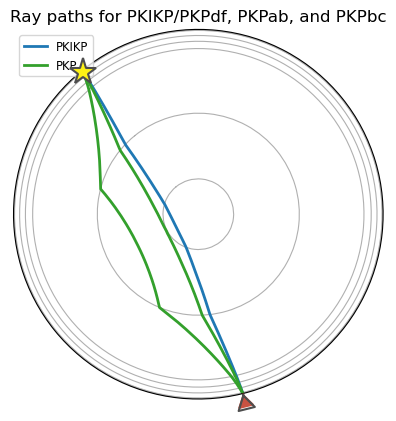

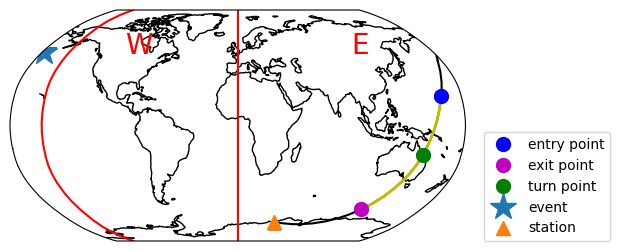

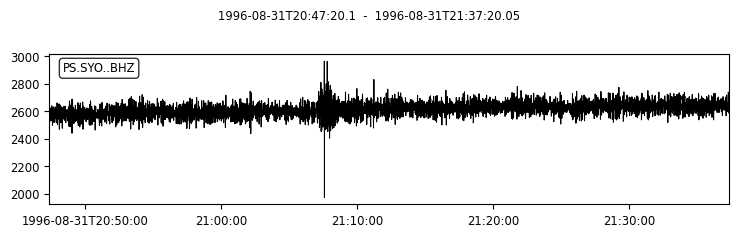

seismogram selected


In [8]:
# 10 source-station pairs are provided. Set index between 0-9 to access each geometry. 
index=0

#select geometry
seis=observed_seismograms[index].copy()
syn=synthetic_seismograms[index].copy()
event = earthquake_catalogue[index].copy()
station = station_inventory[index].copy()

# Get distance, azimuth and backazimuth from event and station locations
distm, azimuth, backazimuth =  obspy.geodetics.base.gps2dist_azimuth(event.origins[0]['latitude'],
                                                        event.origins[0]['longitude'],
                                                          station.latitude,
                                                          station.longitude)
# Convert m to epicentral degrees
distdg = distm/(6371.e3*np.pi/180.)

# Plot waveform
seis.plot(linewidth=0.75)

print('seismogram selected')

## III. Geometry of observation in  the inner core

We want to assess the travel time observations as a function of the angle between the PKIKP path in the inner core and the Earth's rotation axis, which we call $\zeta$.
We can estimate $\zeta$ with

$$cos(\zeta) = \frac{cos(\theta_o)-cos(\theta_i)}{\sqrt{2-2cos(\theta_o)cos(\theta_i)-2sin(\theta_o)sin(\theta_i)cos(\lambda_o-\lambda_i)}}$$

where
 $\theta_i$ and $\theta_o$ are the colatitudes and  $\lambda_i$ and $\lambda_o$ the longitudes  of the entry and exit points of the ray through the inner core. 
 
If $\zeta$ is below 45$^\circ$ it can be categorised as a 'polar' path, and above as an 'equatorial' path. 
 
The following script plots the relevant phases for this particular event-station geometry and computes $\zeta$. Note that the seismic phase naming in ObsPy does not differentiate between PKPbc and PKPab. 



2. Would you characterise the path for PKIKP as a 'polar' or an 'equatorial' path?

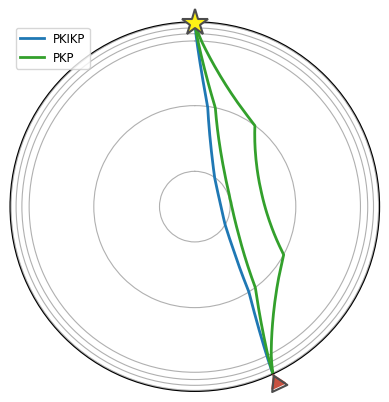

AttributeError: 'Axes' object has no attribute 'set_theta_direction'

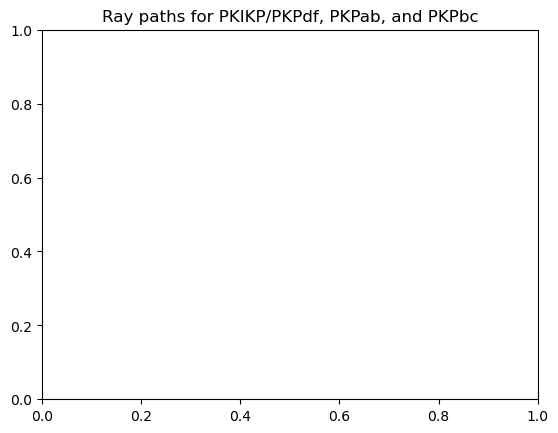

In [9]:
model = TauPyModel(model='iasp91')
# Get event geometry
paths_simple = model.get_ray_paths(source_depth_in_km=event.origins[0]['depth']/1.e3,distance_in_degree=distdg,phase_list=['PKIKP', 'PKP'])

# plot paths
paths_simple.plot_rays(plot_type='spherical', phase_list=['PKIKP', 'PKP'],
                   legend=True)
plt.title('Ray paths for PKIKP/PKPdf, PKPab, and PKPbc')

# Rotate event to its latitude (obspy automatically plots it at the North Pole)
if event.origins[0]['longitude']>0:
    offset = event.origins[0]['latitude']
    if azimuth> 90. and azimuth<270.:
         plt.gca().set_theta_direction(-1)
    else:
          plt.gca().set_theta_direction(+1)  
else:
    offset = 180-event.origins[0]['latitude']
    if azimuth> 90. and azimuth<270.:
         plt.gca().set_theta_direction(+1)
    else:
          plt.gca().set_theta_direction(-1)  
 
  
plt.gca().set_theta_offset(np.deg2rad(np.round(offset)))

# Obtaining the ray path with geographic coordinates
paths_geo = model.get_pierce_points_geo(event.origins[0]['depth']/1.e3 , 
                            event.origins[0]['latitude'], 
                            event.origins[0]['longitude'], 
                            station.latitude, 
                            station.longitude, 
                            phase_list=('PKIKP', ), 
                            resample=False)

# Finding the core entry and exit point
lats =[]
lons=[]
for i in range(len(paths_geo[0].pierce)):
        lats.append(paths_geo[0].pierce[i][4])
        lons.append(paths_geo[0].pierce[i][5])
        # finding core entry point
        if paths_geo[0].pierce[i][3]==5153.9 and paths_geo[0].pierce[i+1][3]>5153.9:
            lat_entry = paths_geo[0].pierce[i][4]
            lon_entry = paths_geo[0].pierce[i][5]
            lat_turn = paths_geo[0].pierce[i+1][4]
            lon_turn = paths_geo[0].pierce[i+1][5]
        # finding core exit point
        if paths_geo[0].pierce[i][3]==5153.9 and paths_geo[0].pierce[i+1][3]<5153.9:
            lat_exit = paths_geo[0].pierce[i][4]
            lon_exit = paths_geo[0].pierce[i][5]
               
# Defining colatitudes (angle from North) in radians
colat_entry_rad = (90-lat_entry)*np.pi/180. # theta_i
colat_exit_rad = (90-lat_exit)*np.pi/180. # theta_o
# Converting to radians
lon_entry_rad = lon_entry*np.pi/180. # lambda_i
lon_exit_rad = lon_exit*np.pi/180.  #lambda_o


#Computing zeta
coszeta = (math.cos(colat_exit_rad)-math.cos(colat_entry_rad))/ \
        (math.sqrt(2-2*math.cos(colat_exit_rad)*math.cos(colat_entry_rad) \
        -2*math.sin(colat_exit_rad)*math.sin(colat_entry_rad)*math.cos(lon_exit_rad-lon_entry_rad)))
zeta= math.acos(coszeta)*180./np.pi

# define zeta as angle between 0-90 from rotation axis
if zeta>90.:
    zeta=180.-zeta
    
    
print('zeta = ', zeta)


## IV. Determine inner core hemisphere

For the inner core, we observe structural variations between two hemispheres. The boundaries between these lie at approximately 0$^\circ$ and 155$^\circ$W and are therefore referred to as 'eastern' and 'western' hemispheres. 

3. Use the map below to determine which hemisphere the deepest point of the ray falls in.

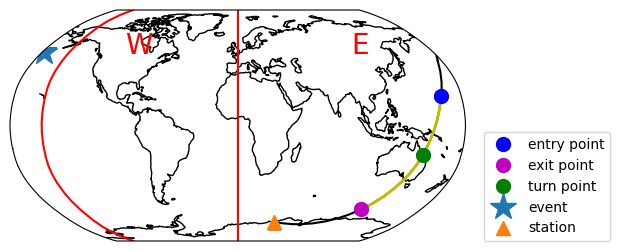

In [10]:
# initialise map
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()

# plot great cir|cle path
for i in range(len(lats)-1):
    ax.plot([lons[i],lons[i+1]], [lats[i],lats[i+1]],'k', transform=ccrs.Geodetic())
ax.plot([lon_entry, lon_exit], [lat_entry, lat_exit],'y', linewidth=2, transform=ccrs.Geodetic())
# plot boundaries between 'eastern' and 'western' hemisphere
ax.plot([-155,-155], [-90,90],'r', transform=ccrs.Geodetic())
ax.plot([0,0], [-90,90],'r', transform=ccrs.Geodetic())
ax.text(-103,50,'W', color='r',fontsize=20,transform=ccrs.Geodetic())
ax.text(103,50,'E', color='r',fontsize=20,transform=ccrs.Geodetic())

# plot entry point to inner core
ax.plot(lon_entry, lat_entry, color='b',marker='o',linewidth=0,  markersize=10, transform=ccrs.Geodetic(), label='entry point')
# plot exit point to inner core
ax.plot(lon_exit, lat_exit, color='m',marker='o', linewidth=0,  markersize=10, transform=ccrs.Geodetic(), label='exit point')
# plot turning point
ax.plot(lon_turn, lat_turn, linewidth=0, color='g',marker='o', markersize=10, transform=ccrs.Geodetic(), label='turn point')
# plot earthquake location
ax.plot(event.origins[0]['longitude'], event.origins[0]['latitude'], linewidth=0, marker='*', markersize=20, transform=ccrs.Geodetic(), label='event')
# plot station location
ax.plot(station.longitude, station.latitude, linewidth=0, marker='^', markersize=10, transform=ccrs.Geodetic(), label = 'station')

plt.legend(loc=(1.04,0))



## V. Differential travel time

We will start by observing the differential arrival time between the PKIKP and PKPbc phase. 


While travel times are often measured at the first upswing (or downswing) of a waveform, this is not often easy to identify for small amplitude phases. It is best to identify the maximum amplitudes of the waves in the synthetics, and then choose the same part of the waveform in the observed data. 

The following bit of code plots the observed and synthetic seismograms around the expected arrivals (highlighted by the red lines). 
The data is filtered between .33 and 1.0 Hz. Note that the synthetics are computed up to 1.0 Hz, so they don't contain any higher frequencies. 


4. Test different frequency bands, i.e. 0.2 -1.0 , 0.1-1.0, 0.05-1.0Hz. What happens to the relative noise levels in the observations as lower frequencies are included? How about the ability to distinguish separate arrivals in the synthetics? 

5. Using the original frequency band, measure travel times of PKPbc and PKPdf in the real data and the synthetic data. Choose  the same identifiable peak in the observed and synthetic waveforms for each phase. 

6. Use the values to calculate
$$ \Delta T_{syn} = Tbc_{syn} -Tdf_{syn}$$ 
and
$$ \Delta T_{obs} = Tbc_{obs} -Tdf_{obs}$$

7. Now calculate the differential time
$$ \Delta T = \Delta T_{obs} - \Delta T_{syn}$$

8. What does a positive or negative value of $\Delta T$ imply in terms of relative velocity in the inner core? 



<Figure size 640x480 with 0 Axes>

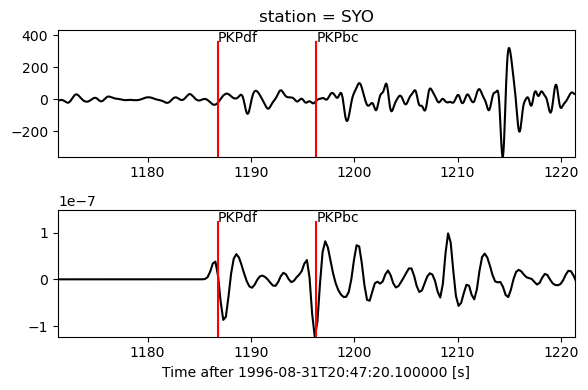

In [11]:
plt.clf()

# Set frequencies
freqmin = .33 #Hz
freqmax = 1.  #Hz



# Filter data
seis_filt= seis.copy()
syn_filt = syn.copy()

seis_filt.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=2, zerophase=False)
syn_filt.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=2, zerophase=False)

# Get phase prediction
ph = 'PKP'
tPKP = model.get_travel_times(source_depth_in_km=event.origins[0]['depth']/1.e3,distance_in_degree=distdg,phase_list=[ph])
tPKPbc = tPKP[0]
tPKPab = tPKP[1]
ph = 'PKIKP'
tPKIKP = model.get_travel_times(source_depth_in_km=event.origins[0]['depth']/1.e3,distance_in_degree=distdg,phase_list=[ph])[0]

# Set window and slice seismograms
window_start=tPKPbc.time-25.
window_end=tPKPbc.time+25.

seis_cut = seis_filt.slice(seis_filt.stats.starttime+window_start,seis_filt.stats.starttime+window_end)
norm_data = np.max(np.abs(seis_cut.data))

syn_cut = syn_filt.slice(syn_filt.stats.starttime+window_start,syn_filt.stats.starttime+window_end)
norm_syn = np.max(np.abs(syn_cut.data))


# Plot seismograms
fig = plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.plot(seis_filt.times(), seis_filt.data, 'k')
plt.xlim(window_start,window_end)
plt.ylim(-norm_data,norm_data*1.2)
plt.plot([tPKPbc.time,tPKPbc.time], [-norm_data,norm_data], 'r')
plt.text(tPKPbc.time, norm_data, 'PKPbc')
plt.plot([tPKIKP.time,tPKIKP.time], [-norm_data,norm_data], 'r')
plt.text(tPKIKP.time, norm_data, 'PKPdf')
plt.title('station = '+ station.code)

plt.subplot(2,1,2)
plt.plot(syn_filt.times(), syn_filt.data, 'k')
plt.xlim(window_start,window_end)
y1,y2 = plt.gca().get_ylim()
plt.ylim(-norm_syn,norm_syn*1.2)
plt.plot([tPKPbc.time,tPKPbc.time], [-norm_syn,norm_syn], 'r')
plt.text(tPKPbc.time, norm_syn, 'PKPbc')
plt.plot([tPKIKP.time,tPKIKP.time], [-norm_syn,norm_syn], 'r')
plt.text(tPKIKP.time, norm_syn, 'PKPdf')


plt.gca().set_xlabel("Time after %s [s]" % seis.stats.starttime.isoformat())
plt.tight_layout()


plt.show()


## Repeat for several polar and equatorial paths

9. Next determine the hemisphere (E/W), value of $\zeta$ and the travel times for the other nine geometries recorded. You can record these as the table below, which is replicated in the code block  (replace the text in the coded table). Values for the first measurement are filled in for you to check or replace with your own values.  


| index | Earthquake time | Station | Hemisphere (E/W) | $\zeta$ value| $Tbc_{syn}$ | $Tdf_{syn}$  | $Tbc_{obs}$ | $Tdf_{obs}$ |
| :- | :- | :-  | :-  | :-  | :- | :- | :-  | :-  | 
| 0 | 1996-08-31T20:47 | SYO | -- | -- |  -- |  -- | -- | -- |  
| 1 | 1997-06-17T21:03 | SYO | -- | -- |  -- |  -- | -- | -- |  
| 2 | 1997-10-05T18:04 | NRIL | -- | -- |  -- |  -- | -- | -- |  
| 3 | 1997-12-11T07:56 | KMI | -- | -- |  -- |  -- | -- | -- |  
| 4 | 1998-09-03T17:37 | HYB | -- | -- |  -- |  -- | -- | -- |  
| 5 | 2002-03-09T12:27 | COLA | -- | -- |  -- |  -- | -- | -- |  
| 6 | 2002-10-03T19:05 | LVC | -- | -- |  -- |  -- | -- | -- |  
| 7 | 2002-11-12T01:46 | TLY | -- | -- |  -- |  -- | -- | -- | 
| 8 | 2004-10-08T15:28 | PMR | -- | -- |  -- |  -- | -- | -- |  
| 9 | 2006-01-18T03:52 | SAML | -- | -- |  -- |  -- | -- | -- |  

The script below will plot the differential time as a function of $\zeta$, colouring the data by hemisphere. Note that the code will continue to give an error if not all values are filled in. 

10. What trends do you observe? What kind of inner core structure could explain these observations? What are potential hypothesis for the cause of this structure? 

11. Take the most extreme travel time variation between a polar and an equatorial path for a specific hemisphere. How much does the mean inner core velocity need to vary between these paths to explain these travel times variations? Use Figure 3 to estimate the ray path length of a PKPdf (PKIKP) phase (the radius of the inner core is 1220 km). Use a reference inner core velocity of 13 km/s. What is the percentage velocity change between polar and equatorial (i.e. the percentage of anisotropy)? What is the percentage for the other hemisphere? 



In [12]:
# Formatting results in panda data frame
import pandas as pd

#define hemisphere categories
[E,W]=["E", "W"]
# index, hemisphere, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs
data = [[0, E, 28.5, 1196.2, 1187.3, 1199.2, 1189.7 ], 
 [1, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs], 
 [2, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs] , 
 [3, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs] , 
 [4, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs], 
 [5, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs], 
 [6, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs], 
 [7, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs], 
 [8, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs], 
 [9, E/W, zeta, tbc_syn, tdf_syn, tbc_obs, tdf_obs]]


# create a data frame used in Pandas (a python library for data analyses)
df = pd.DataFrame (data)
df.columns = ['index','hemisphere','zeta','tbc_syn','tdf_syn','tbc_obs','tdf_obs']
df["hemisphere"] = df["hemisphere"].astype("category")

# compute differential times
df['deltaT_syn']=df['tbc_syn']-df['tdf_syn']
df['deltaT_obs']=df['tbc_obs']-df['tdf_obs']
df['deltaT']=df['deltaT_obs']-df['deltaT_syn']
print(df)

# plot coloured by hemisphere
df.plot.scatter(x="zeta", y="deltaT", c="hemisphere", cmap="viridis", s=50);
df.to_csv('answers.txt')

TypeError: unsupported operand type(s) for /: 'str' and 'str'